Running grid: 100%|██████████| 101/101 [00:12<00:00,  8.41it/s]


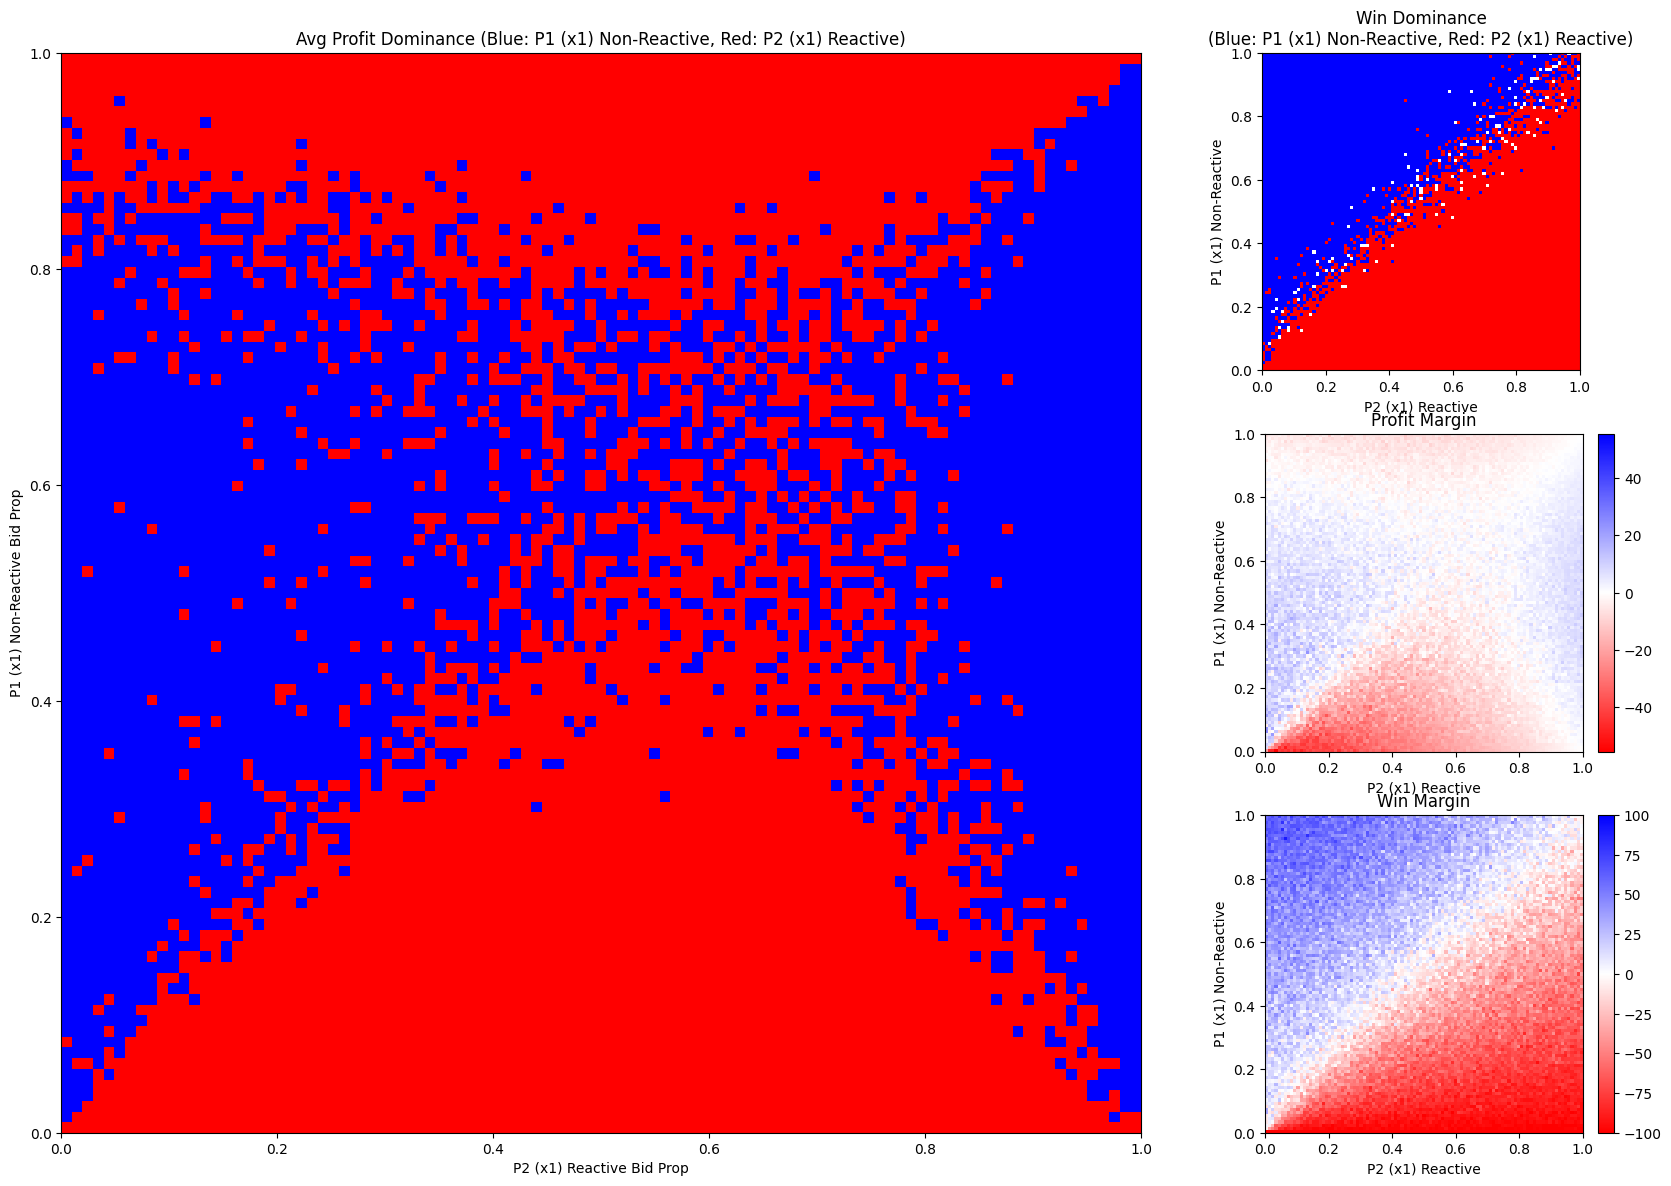

In [ ]:
# Bid Prop Analysis

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

from auction import Auction
from player import RangePlayer

# Settings
bid_props = np.round(np.linspace(0, 1, 101), 2)
n = len(bid_props)
n_rounds = 100
speed_range = (0.0, 0.5)
cutoff_time_range = (1.0, 1.0)
sealed_bids = True

# Team config
team1_size, team2_size = 1, 1
team1_reactive, team2_reactive = False, True

def label(name, size, reactive):
    return f"{name} (x{size}){' Reactive' if reactive else ' Non-Reactive'}"

p1_label = label("P1", team1_size, team1_reactive)
p2_label = label("P2", team2_size, team2_reactive)

# Result matrices
profit_matrix = np.zeros((n, n))
win_matrix = np.zeros((n, n))
profit_margin = np.zeros((n, n))
win_margin = np.zeros((n, n))

for i, p1_bid in enumerate(tqdm(bid_props, desc="Running grid")):
    for j, p2_bid in enumerate(bid_props):
        team1 = [RangePlayer(1 + k, speed_range, [p1_bid, 0.0], team1_reactive) for k in range(team1_size)]
        team2 = [RangePlayer(100 + k, speed_range, [p2_bid, 0.0], team2_reactive) for k in range(team2_size)]
        auction = Auction(team1 + team2, cutoff_time_range, sealed_bids)
        results, winnings = auction.run_simulation(n_rounds)

        # Profit per team (average)
        p1_total = sum(winnings[k] for k in range(team1_size))
        p2_total = sum(winnings[team1_size + k] for k in range(team2_size))
        p1_avg = p1_total / team1_size
        p2_avg = p2_total / team2_size
        profit_margin[i, j] = p1_avg - p2_avg
        profit_matrix[i, j] = 1 if p1_avg > p2_avg else 2 if p2_avg > p1_avg else 0

        # Win counts
        p1_wins = sum(1 for r in results if r['winner'] and r['winner'][0] < 100)
        p2_wins = n_rounds - p1_wins
        p1_win_avg = p1_wins / team1_size
        p2_win_avg = p2_wins / team2_size
        win_margin[i, j] = p1_win_avg - p2_win_avg
        win_matrix[i, j] = 1 if p1_win_avg > p2_win_avg else 2 if p2_win_avg > p1_win_avg else 0

# --- Plotting ---
flat_cmap = ListedColormap(['white', 'blue', 'red'])
norm = BoundaryNorm([0, 0.5, 1.5, 2.5], flat_cmap.N)

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 4, figure=fig, wspace=0.05)

ax1 = fig.add_subplot(gs[:, :3])
ax1.imshow(profit_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax1.set_title(f"Avg Profit Dominance (Blue: {p1_label}, Red: {p2_label})")
ax1.set_xlabel(f"{p2_label} Bid Prop")
ax1.set_ylabel(f"{p1_label} Bid Prop")

ax2 = fig.add_subplot(gs[0, 3])
ax2.imshow(win_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax2.set_title(f"Win Dominance\n(Blue: {p1_label}, Red: {p2_label})")
ax2.set_xlabel(f"{p2_label}")
ax2.set_ylabel(f"{p1_label}")

ax3 = fig.add_subplot(gs[1, 3])
grad1 = ax3.imshow(profit_margin, origin='lower', extent=[0, 1, 0, 1],
                   cmap='bwr_r', vmin=-np.max(np.abs(profit_margin)), vmax=np.max(np.abs(profit_margin)))
ax3.set_title("Profit Margin")
ax3.set_xlabel(f"{p2_label}")
ax3.set_ylabel(f"{p1_label}")
fig.colorbar(grad1, ax=ax3, fraction=0.046, pad=0.04)

ax4 = fig.add_subplot(gs[2, 3])
grad2 = ax4.imshow(win_margin, origin='lower', extent=[0, 1, 0, 1],
                   cmap='bwr_r', vmin=-np.max(np.abs(win_margin)), vmax=np.max(np.abs(win_margin)))
ax4.set_title("Win Margin")
ax4.set_xlabel(f"{p2_label}")
ax4.set_ylabel(f"{p1_label}")
fig.colorbar(grad2, ax=ax4, fraction=0.046, pad=0.04)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()